In [35]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [36]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall
import PyPlot; const plt = PyPlot ;

In [37]:
df = CSV.read("SI_pcp-saft_parameters.csv",DataFrame,header=1) ;
fieldnames(typeof(df))
#display(names(df)[1:20]) ;
writedlm("out.txt", names(df), ' ') ;

replace!(df.mu, missing => 0) ;
replace!(df.kappa_ab, missing => 0) ;
replace!(df.epsilon_k_ab, missing => 0) ;

df.mu = Float64.(df.mu)
df.kappa_ab = Float64.(df.kappa_ab)
df.epsilon_k_ab = Float64.(df.epsilon_k_ab) ;
df = sort(df, :molarweight) ;
df

Row,common_name,iupac_name,inchi,canonical_smiles,isomeric_smiles,cas,family,molarweight,m,sigma,epsilon_k,mu,kappa_ab,epsilon_k_ab,na,nb,mard_psat,t_min_psat,t_max_psat,points_psat,mard_psat_incl_outlier,points_psat_incl_outlier,mard_density,t_min_density,t_max_density,points_density_liquid,mard_density_liquid_single_phase,points_density_liquid_single_phase,mard_density_equi,points_density_equi,mard_density_vapor,points_density_vapor,opt,bounds_violation
,String,String?,String,String,String,String15,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String15,String
1,methane,methane,InChI=1S/CH4/h1H4,C,C,74-82-8,Alkanes,16.031,1.0,3.70051,150.071,0.0,0.0,0.0,0,0,0.59,90.67,191.05,1211,0.72,1222,0.53,90.68,180.98,1126,0.48,856.0,0.68,270.0,2.65,4317.0,NONPOLAR,m: lower
2,ammonia,azane,InChI=1S/H3N/h1H3,N,N,7664-41-7,Inorganic compounds,17.027,2.44608,2.3709,213.571,0.0,0.0001,200.0,1,1,1.23,195.45,406.05,1082,1.4,1093,1.42,199.96,385.23,879,1.38,775.0,1.7,104.0,10.78,180.0,ASSOCIATIVE,"kappa_ab: lower, epsilon_k_ab: lower"
3,ammonia-d3,missing,InChI=1S/H3N/h1H3/i/hD3,N,[2H]N([2H])[2H],13550-49-7,Other compounds,17.027,2.77559,2.0918,129.266,0.0,0.9,1233.56,1,1,0.27,200.0,294.06,231,0.31,232,0.09,205.24,293.15,20,0.13,12.0,0.04,8.0,missing,missing,ASSOCIATIVE,kappa_ab: higher
4,water,oxidane,InChI=1S/H2O/h1H2,O,O,7732-18-5,Inorganic compounds,18.011,2.36948,2.15072,230.716,0.0,0.35319,2195.1,1,1,1.1,273.16,650.65,5870,1.18,5896,2.21,270.15,613.15,6342,2.23,6244.0,0.76,98.0,7.52,1827.0,ASSOCIATIVE,OK
5,tritium oxide,missing,InChI=1S/H2O/h1H2/i/hT2,O,[3H]O[3H],14940-65-9,Other compounds,18.011,2.63111,1.99608,344.334,0.0,0.0,0.0,0,0,0.18,283.15,374.75,7,0.18,7,0.79,278.13,326.19,40,0.79,40.0,missing,missing,missing,missing,NONPOLAR,OK
6,hydrogen fluoride,fluorane,InChI=1S/FH/h1H,F,F,7664-39-3,Inorganic compounds,20.006,1.23675,2.90791,322.584,1.82,0.0,0.0,0,0,4.81,201.5,461.15,277,5.44,279,8.36,199.25,433.65,97,8.41,73.0,8.23,24.0,22.26,360.0,DIPOLAR,OK
7,ethyne,acetylene,InChI=1S/C2H2/c1-2/h1-2H,C#C,C#C,74-86-2,Alkynes,26.016,2.22087,2.87502,166.034,0.0,0.0,0.0,0,0,0.82,192.15,310.05,106,1.64,111,1.0,189.54,290.23,41,0.34,10.0,1.22,31.0,missing,missing,NONPOLAR,OK
8,hydrogen cyanide,formonitrile,InChI=1S/CHN/c1-2/h1H,C#N,C#N,74-90-8,Nitriles,27.011,2.72334,2.64506,170.345,2.98,0.0,0.0,1,0,4.43,259.856,456.75,343,4.49,344,1.2,259.0,433.15,115,1.23,109.0,0.63,6.0,missing,missing,DIPOLAR,OK
9,carbon monoxide,carbon monoxide,InChI=1S/CO/c1-2,[C-]#[O+],[C-]#[O+],630-08-0,Inorganic compounds,27.995,1.32286,3.24532,91.1709,0.0,0.0,0.0,0,0,1.97,68.19,132.92,220,2.45,227,0.55,68.13,125.97,144,0.5,88.0,0.63,56.0,0.38,9.0,NONPOLAR,OK


In [38]:
# Info for Clapeyron Database File:
# species Mw segment sigma epsilon dipole n_H n_e source
num_rows = nrow(df)
df2 = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    source = fill(missing, num_rows)
) ;


In [39]:
df2.species = df.common_name
df2.Mw = df.molarweight
df2.isomeric_SMILES = df.isomeric_smiles
df2.family = df.family
df2.segment = df.m
df2.sigma = df.sigma
df2.epsilon = df.epsilon_k
df2.dipole = df.mu
df2.kappa_ab = df.kappa_ab
df2.epsilon_k_ab = df.epsilon_k_ab
df2[!, :source] .= "10.1021/acs.iecr.3c02255" ;

In [40]:
filtered_data_chem_family = filter(row -> occursin("Alkane", row.family), df2) ;
filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 

species_names = filtered_data_chem_family.species ;

#println(filtered_data_chem_family)

In [41]:
model = PPCSAFT(["methane"])

PPCSAFT{BasicIdeal} with 1 component:
 "methane"
Contains parameters: Mw, segment, sigma, epsilon, dipole, dipole2, epsilon_assoc, bondvol

In [42]:
models = [PPCSAFT(i) for i in species_names];

In [43]:
critical_props = crit_pure.(models)

n = 200

temp_ranges = [collect(range(0.5*critical_props[i][1],0.99*critical_props[i][1],n)) for i in 1:length(critical_props)] ;
sat_props = [[saturation_pressure(models[j],temp_ranges[j][i]) for i ∈ 1:n] for j in 1:length(critical_props)] ;

sat_pressures = [[sat_props[j][i][1] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_liq = [[sat_props[j][i][2] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_vap = [[sat_props[j][i][3] for i ∈ 1:n] for j in 1:length(critical_props)] ;

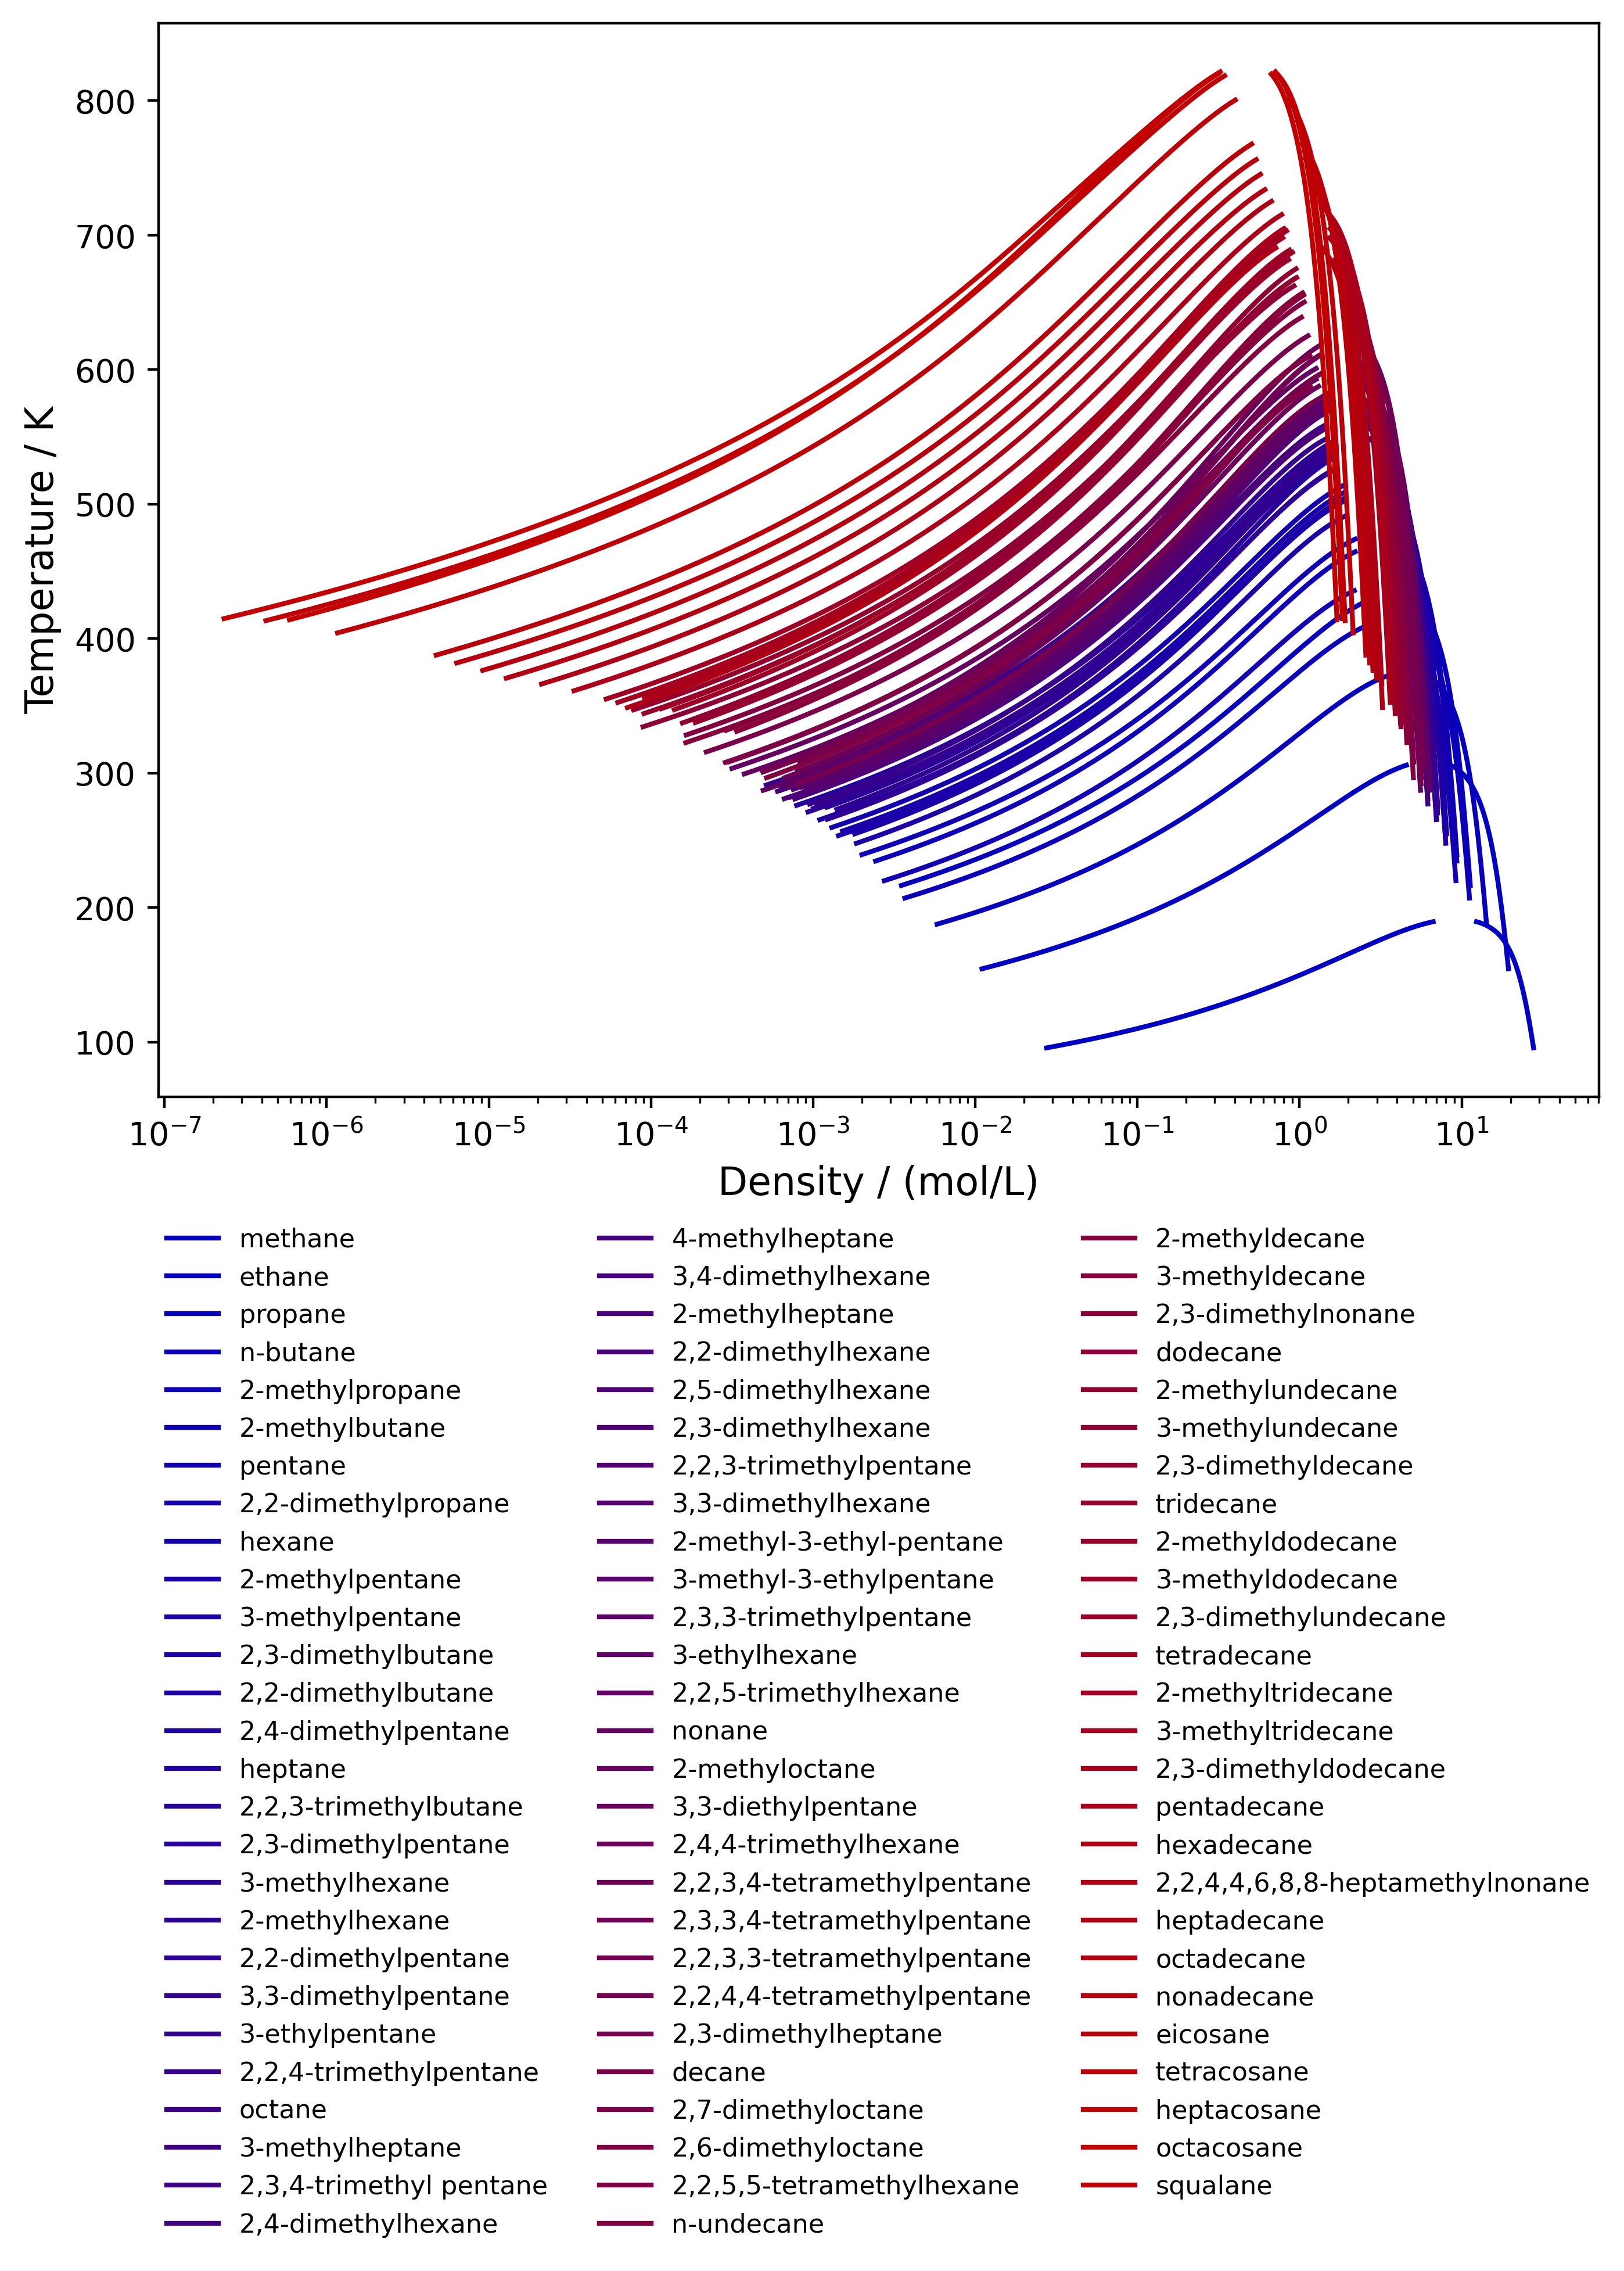

In [44]:
colour_grad_1 = collect(range(1,194,length(species_names)) ./255) 
colour_grad_2 = collect(range(194,1,length(species_names)) ./255)

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(species_names)

plt.semilogx(1e-3 ./sat_vols_liq[i],temp_ranges[i],label=species_names[i], color = [colour_grad_1[i] 0 colour_grad_2[i]])
plt.semilogx(1e-3 ./sat_vols_vap[i],temp_ranges[i],color = [colour_grad_1[i] 0 colour_grad_2[i]])

end

plt.legend(loc="upper center",bbox_to_anchor =(0.5,-0.1),frameon=false,fontsize=8,ncol=3) 
plt.xlabel("Density / (mol/L)",fontsize=12)
plt.ylabel("Temperature / K",fontsize=12)

plt.savefig("alkane_envelopes.png",dpi=400)


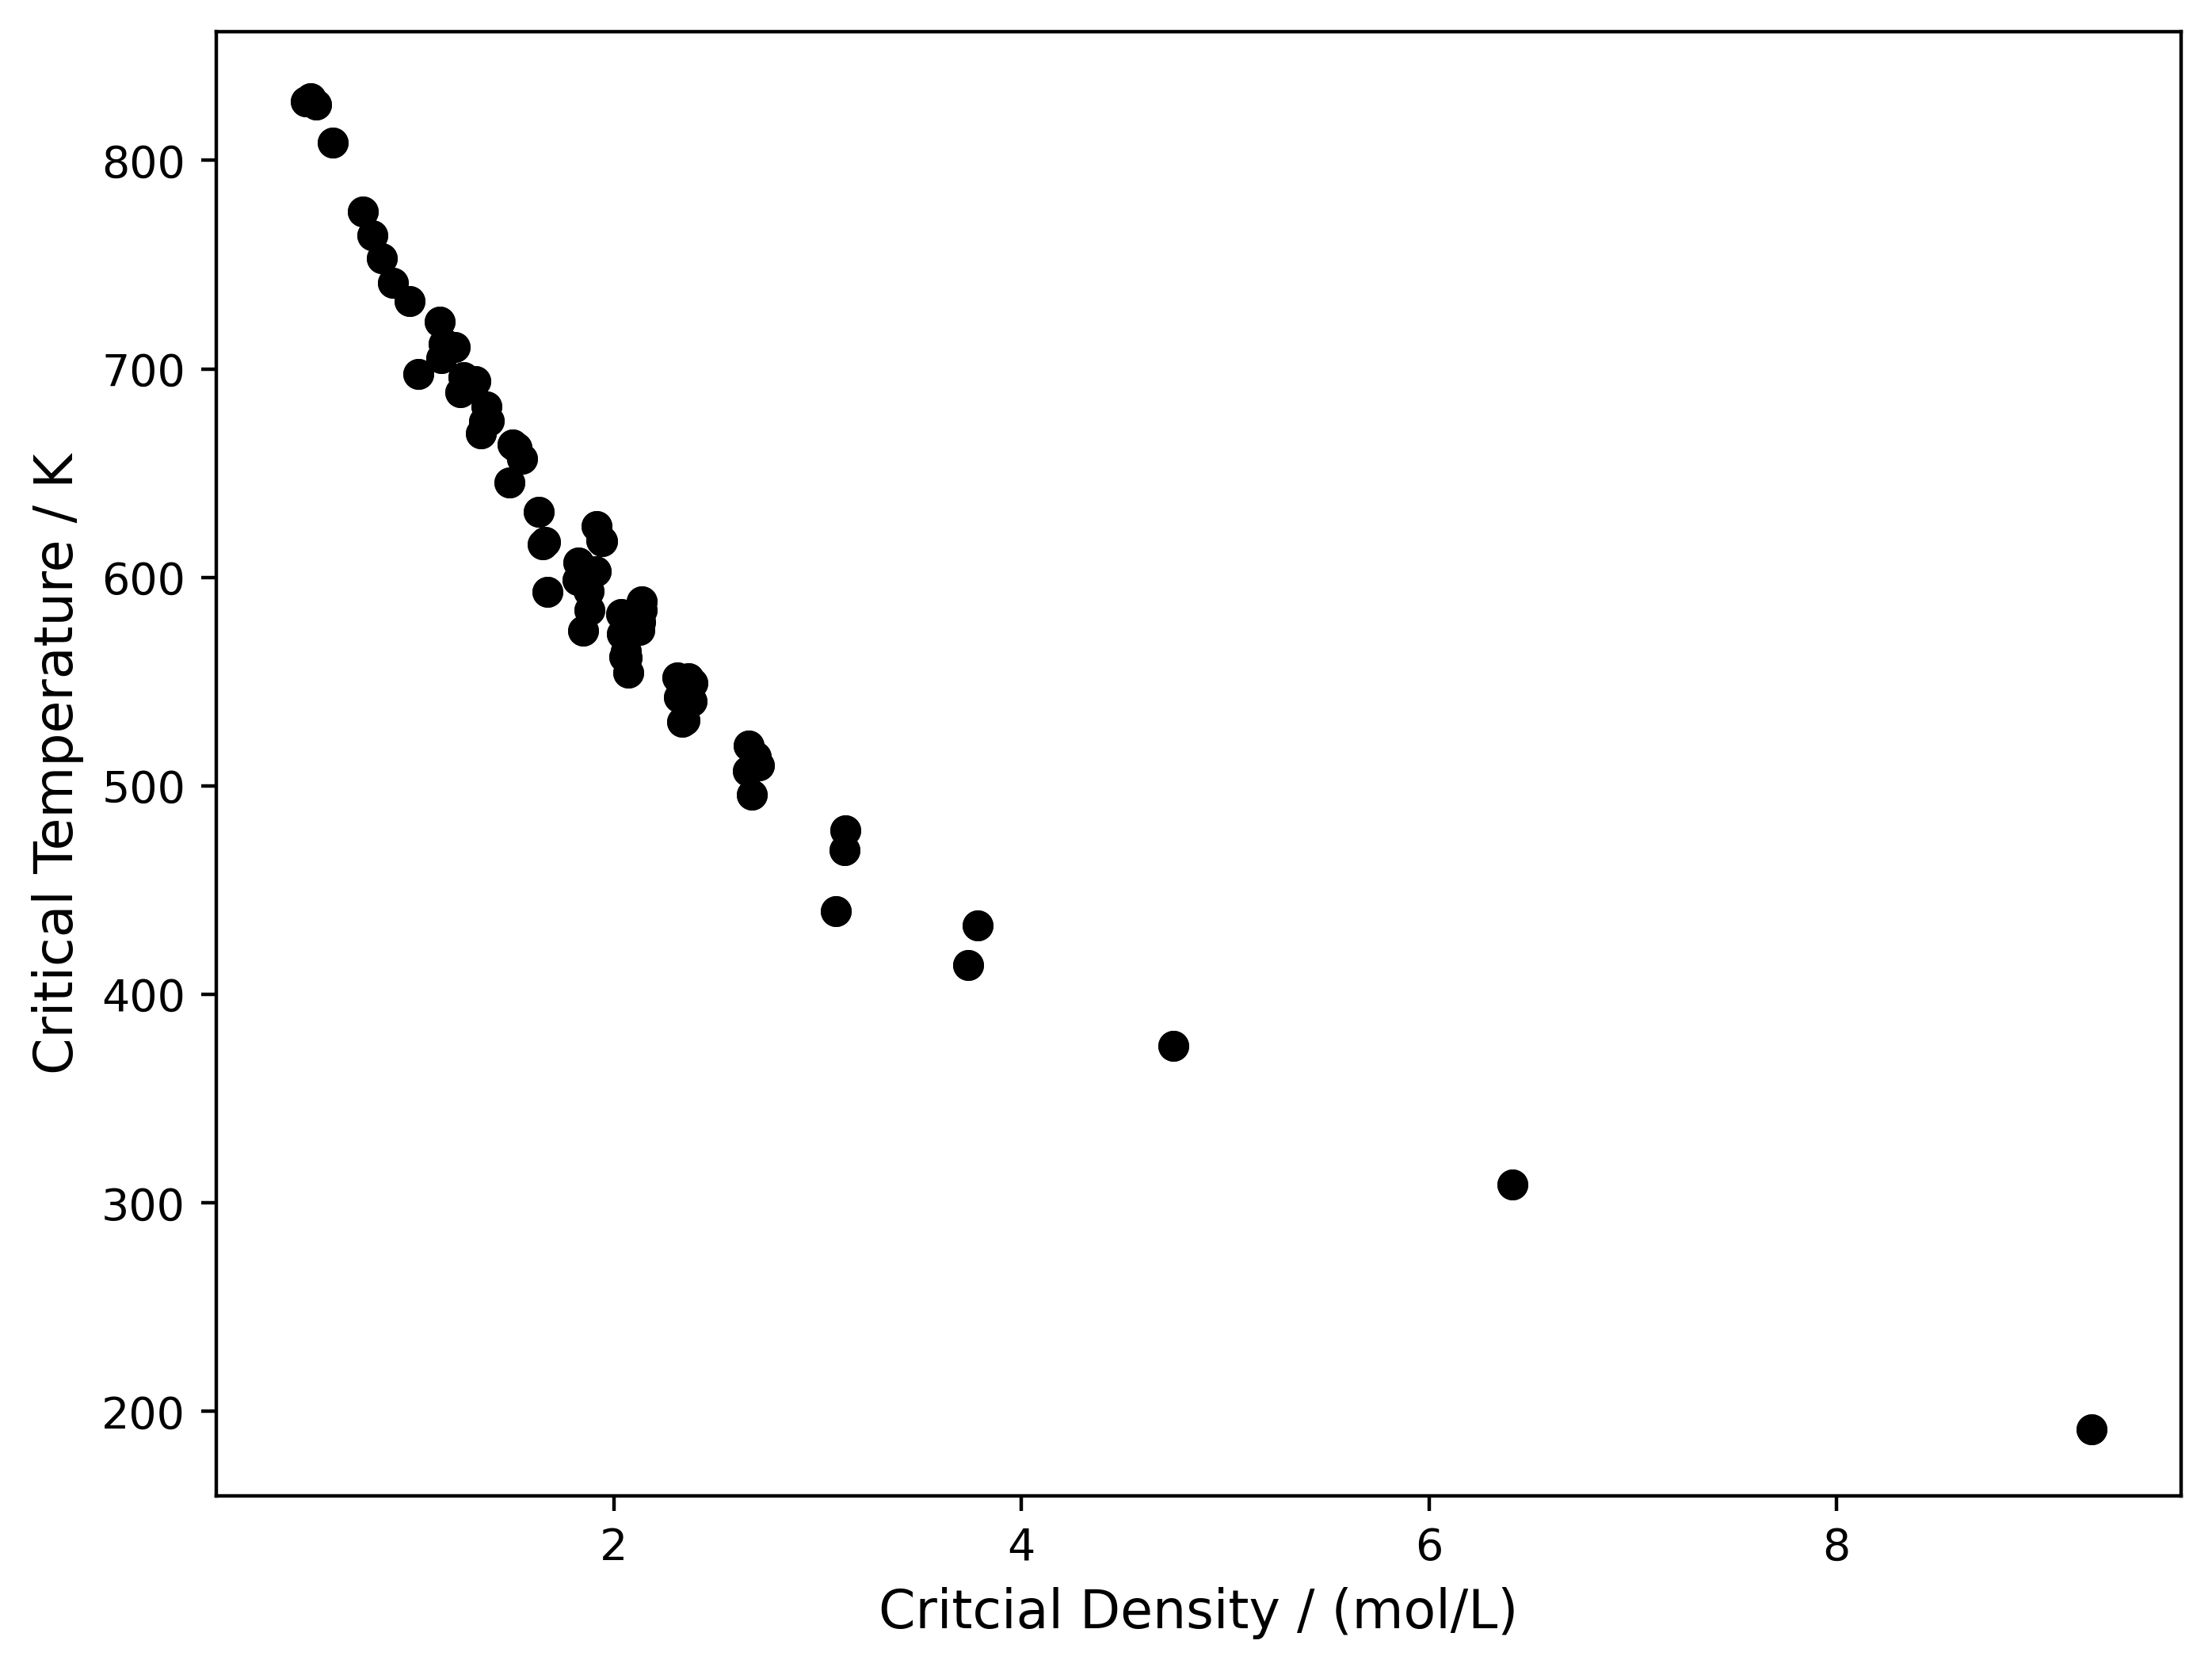

In [45]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(species_names)
plt.scatter(1e-3 ./critical_props[i][3],critical_props[i][1], color = "black")
plt.scatter(1e-3 ./critical_props[i][3],critical_props[i][1],color = "black")
end

plt.xlabel("Critcial Density / (mol/L)",fontsize=12)
plt.ylabel("Critical Temperature / K",fontsize=12)
plt.savefig("alkane_envelopes.png",dpi=400)


In [53]:
test_species_exptl_data = DataFrame(CSV.File("test_species_exptl_data.csv")) ; 
test_species_exptl_data


Row,Temperature (K),Pressure (bar),Density (mol/l),Volume (l/mol),Internal Energy (kJ/mol),Enthalpy (kJ/mol),Entropy (J/mol*K),Cv (J/mol*K),Cp (J/mol*K),Sound Spd. (m/s),Joule-Thomson (K/bar),Viscosity (uPa*s),Therm. Cond. (W/m*K),Phase,Column15,Column16
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,String15,String7?,Int64
1,91.0,0.12164,16.204,61.713,6.8382,7.5889,84.667,25.25,33.866,249.51,4.7514,3.608,0.0088333,vapor,missing,16204
2,91.165,0.12423,16.521,60.53,6.8421,7.5941,84.55,25.254,33.874,249.72,4.7298,3.6135,0.0088521,vapor,missing,16521
3,91.33,0.12686,16.842,59.374,6.846,7.5992,84.434,25.257,33.882,249.93,4.7083,3.619,0.008871,vapor,missing,16842
4,91.495,0.12954,17.169,58.245,6.8499,7.6044,84.318,25.261,33.89,250.13,4.6869,3.6245,0.0088899,vapor,missing,17169
5,91.66,0.13226,17.5,57.141,6.8538,7.6096,84.203,25.265,33.898,250.34,4.6658,3.63,0.0089088,vapor,missing,17500
6,91.825,0.13503,17.837,56.063,6.8577,7.6147,84.088,25.268,33.907,250.54,4.6448,3.6355,0.0089277,vapor,missing,17837
7,91.99,0.13784,18.179,55.01,6.8616,7.6199,83.974,25.272,33.915,250.75,4.624,3.6411,0.0089467,vapor,missing,18179
8,92.155,0.14071,18.525,53.98,6.8655,7.625,83.861,25.276,33.924,250.95,4.6033,3.6466,0.0089656,vapor,missing,18525
9,92.32,0.14362,18.877,52.973,6.8694,7.6302,83.748,25.28,33.932,251.15,4.5828,3.6521,0.0089847,vapor,missing,18877


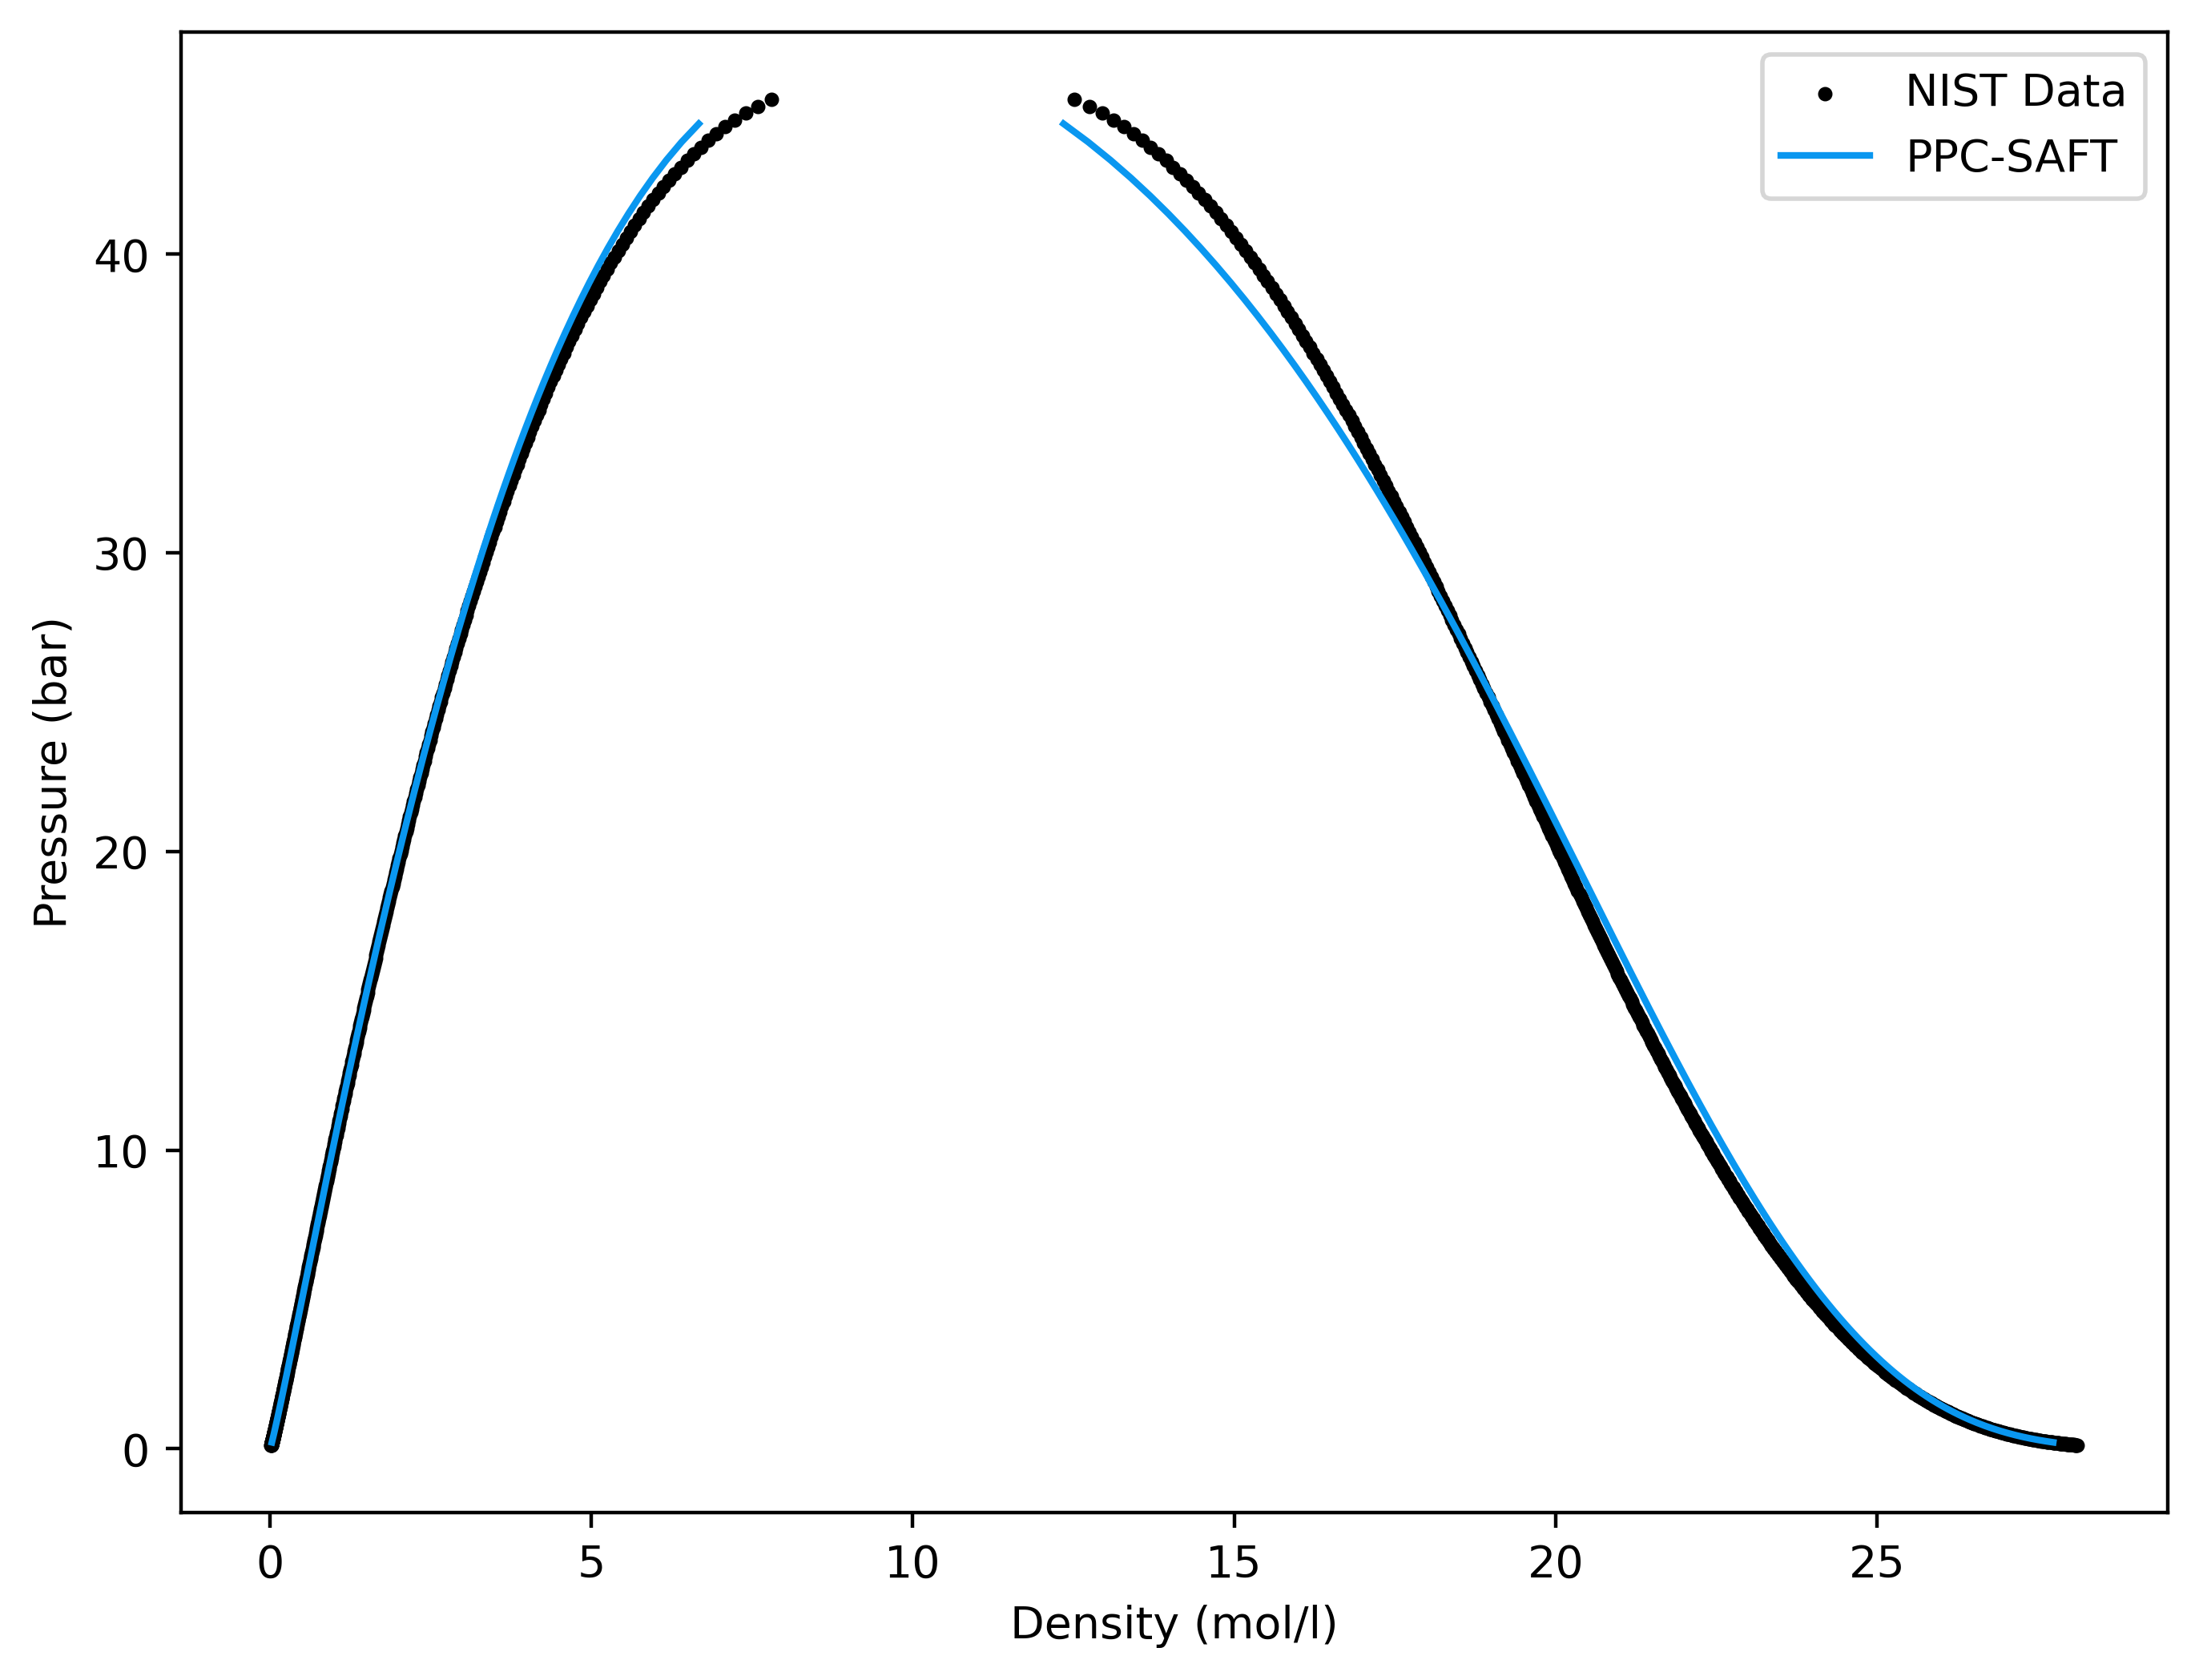

In [92]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(test_species_exptl_data[!,"Density (mol/l)"] ./1000,test_species_exptl_data[!,"Pressure (bar)"],s=5,color="black")
plt.plot(1e-3 ./sat_vols_vap[1],sat_pressures[1] ./10^5, color="#0a97f0")
plt.plot(1e-3 ./sat_vols_liq[1],sat_pressures[1] ./10^5, color="#0a97f0")

plt.xlabel("Density (mol/l)") ;
plt.ylabel("Pressure (bar)") ;
plt.legend(["NIST Data","PPC-SAFT"]) ;